Based on https://arxiv.org/abs/1712.09665 - Adversarial Patch - Brown et al., 2017. In this notebook, the adversarial patch attack is performed. This kind of attack profressively modifies a patch of the image during training. The aim is to produce a missprediction of the model. After training, the resulting patch could be used as a "sticker", and be placed both in test images and on objects in "real life". Watch short preview at [this link](https://www.youtube.com/watch?v=i1sp4X57TL4&feature=youtu.be).

This kind of attack, differently from FGSM or PGD that perturb the whole image, modifies a predefined confined region. E.g., when dealing with autonomous driving, the patch could be attached to a street sign, potentially causing a missprediction (stop sign recognized as yield sign.)

In this notebook, we apply the idea to medical images. We try to produce a "sticker" to be placed on tumor images, and eventually obtain a no-tumor classification with high confidence by the model.

To counterbalance such attack, robust data agumentation pipelines should be implemented. However, as stated in the referenced paper, a "universal adversarial patch" could be crafted "a priori" on the target dataset and potentially cause catastrophic effects.

In [115]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import cv2
import random
from random import randint
import matplotlib.pyplot as plt

# reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [117]:
class StickMe:
    def __init__(self, model, device, patch_init=None, patch_size=32, target_class=2, steps=1, lr=0.0005):
        self.model = model
        self.device = device
        self.patch_size = patch_size
        self.target_class = target_class
        self.steps = steps
        self.lr = lr

        # start from initialized or random patch
        if patch_init != None:
            self.patch = patch_init
            self.patch.requires_grad_()
        else:
            self.patch = torch.randn(3, patch_size, patch_size, requires_grad=True)
    
        self.optimizer = optim.Adam([self.patch], lr=self.lr)

    def apply_patch_to_image(self, image):
        image_clone = image.clone()
        x = randint(0, image.size(1) - self.patch_size)
        y = randint(0, image.size(2) - self.patch_size)
        image_clone[:, x:x+self.patch_size, y:y+self.patch_size] = self.patch
        return image_clone

    def generate_patch(self, images):
        for step in range(self.steps):
            # stick to image
            images_with_patch = torch.empty(images.shape)
            images_with_patch = images_with_patch.to(self.device)
            for i, image in enumerate(images):
                images_with_patch[i] = self.apply_patch_to_image(image)
            
            # get model predictions
            outputs = self.model(images_with_patch)

            # smt like [2,2,2,2,...]
            target_labels = torch.full((images.size(0),), self.target_class, dtype=torch.long).to(self.device)

            # CE loss
            loss = nn.CrossEntropyLoss()(outputs, target_labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # clamp patch
            with torch.no_grad():
                self.patch.clamp_(-2, 0)
        
        return self.patch

Importing train and test images

In [118]:
dataset_folder = "mri_brain_tumor"

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

min value in image 860: -2.1179
max value in image 860: 2.0823
mean value in image 860: -1.3705
std value in image 860: 0.6506


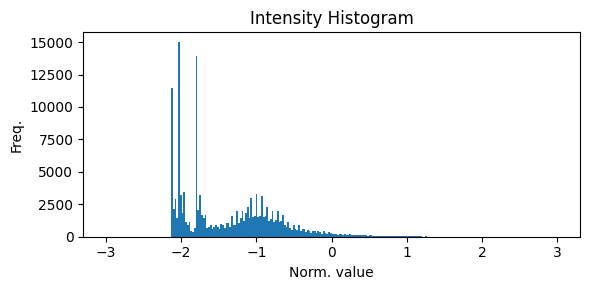

In [119]:
idx = np.random.randint(len(train_dataset))
flat_img = train_dataset[idx][0].flatten()

print(f"min value in image {idx}: {min(flat_img).item():.4f}")
print(f"max value in image {idx}: {max(flat_img).item():.4f}")
print(f"mean value in image {idx}: {torch.mean(flat_img).item():.4f}")
print(f"std value in image {idx}: {torch.std(flat_img).item():.4f}")

plt.figure(figsize=[6,3])
plt.hist(flat_img, bins=256, range=(-3, +3))
plt.title("Intensity Histogram")
plt.xlabel("Norm. value")
plt.ylabel("Freq.")
plt.tight_layout()
plt.show()

Importing ResNet18 and fine-tuned weights.

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using', device.type)

using cuda


In [41]:
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params/(10**6):.3f} M")

model_save_path = f"weights/resnet_clean.pth"
model.load_state_dict(torch.load(model_save_path))

Total number of parameters: 11.179 M


<All keys matched successfully>

In [133]:
from utils import CNN
model = CNN().to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params/(10**6):.3f} M")

model_save_path = f"weights/cnn_clean_10_epochs.pth"
model.load_state_dict(torch.load(model_save_path))

Total number of parameters: 51.476 M


<All keys matched successfully>

Sticker generator 😼

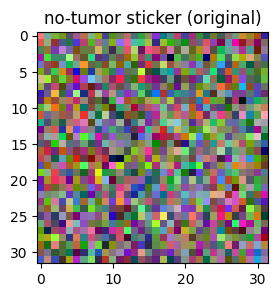

In [122]:
sticker_generator = StickMe(model, device)

def denorm_and_show(image, title):
    plt.figure(figsize=[3,3])
    image = image.detach()
    image = image * std[:, None, None] + mean[:, None, None]
    image = image.clip(0, 1)
    image = np.transpose(image.numpy(), (1, 2, 0))
    plt.title(title)
    plt.imshow(image)

denorm_and_show(sticker_generator.patch, 'no-tumor sticker (original)')

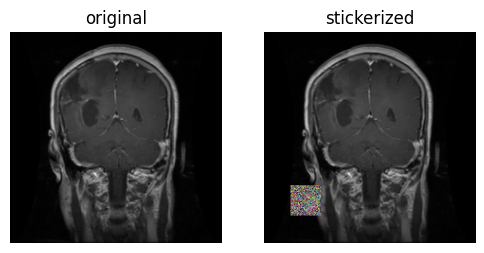

In [123]:
def denorm_and_show_images(list_of_images, list_of_titles):
    cols = len(list_of_images)
    _, axes = plt.subplots(1, cols, figsize=(6, 3))

    for i, ax in enumerate(axes):
        image = list_of_images[i]
        image = image.detach()
        image = image * std[:, None, None] + mean[:, None, None]
        image = image.clip(0, 1)
        image = np.transpose(image.numpy(), (1, 2, 0))
        ax.imshow(image)
        ax.set_title(f"{list_of_titles[i]}")
        ax.axis('off')

    plt.axis('off')
    plt.show()

images = next(iter(train_loader))[0]
image = images[0]
image_with_sticker = sticker_generator.apply_patch_to_image(image)
denorm_and_show_images([image, image_with_sticker], ['original', 'stickerized'])

In [110]:
images = next(iter(train_loader))[0]

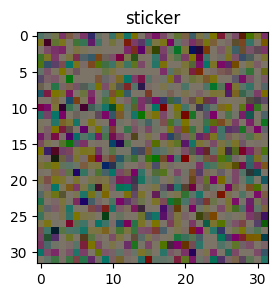

In [111]:
images = images.to(device)
sticker = sticker_generator.generate_patch(images)
denorm_and_show(sticker_generator.patch, 'sticker')

In [124]:
model.eval()
num_epochs = 5
sticker_over_epochs = []

for epoch in range(num_epochs):
    print(f"+------ epoch {epoch+1}/{num_epochs} -------+")
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        sticker = sticker_generator.generate_patch(images)

        if (i+1) % 64 == 0:
            print(f"Batch [{i+1}/{len(train_loader)}]")
    
    sticker_over_epochs.append(sticker)


+------ epoch 1/5 -------+
Batch [64/714]
Batch [128/714]
Batch [192/714]
Batch [256/714]
Batch [320/714]
Batch [384/714]
Batch [448/714]
Batch [512/714]
Batch [576/714]
Batch [640/714]
Batch [704/714]
+------ epoch 2/5 -------+
Batch [64/714]
Batch [128/714]
Batch [192/714]
Batch [256/714]
Batch [320/714]
Batch [384/714]
Batch [448/714]
Batch [512/714]
Batch [576/714]
Batch [640/714]
Batch [704/714]
+------ epoch 3/5 -------+
Batch [64/714]
Batch [128/714]
Batch [192/714]
Batch [256/714]
Batch [320/714]
Batch [384/714]
Batch [448/714]
Batch [512/714]
Batch [576/714]
Batch [640/714]
Batch [704/714]
+------ epoch 4/5 -------+
Batch [64/714]
Batch [128/714]
Batch [192/714]
Batch [256/714]
Batch [320/714]
Batch [384/714]
Batch [448/714]
Batch [512/714]
Batch [576/714]
Batch [640/714]
Batch [704/714]
+------ epoch 5/5 -------+
Batch [64/714]
Batch [128/714]
Batch [192/714]
Batch [256/714]
Batch [320/714]
Batch [384/714]
Batch [448/714]
Batch [512/714]
Batch [576/714]
Batch [640/714]
Batch 

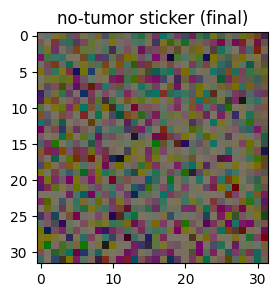

In [125]:
denorm_and_show(sticker, 'no-tumor sticker (final)')

Attack sticker in test images and calculate metrics

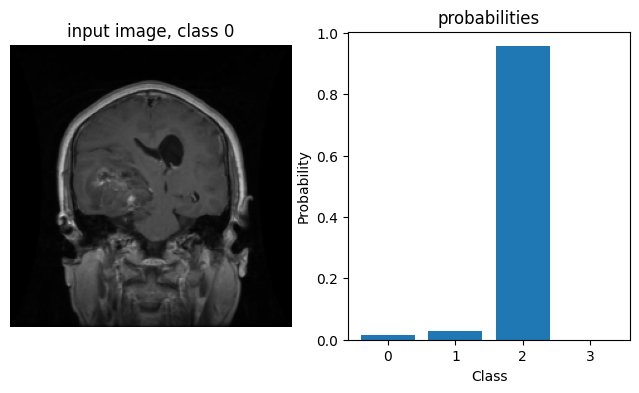

In [141]:
import torch.nn.functional as F
def show_softmax_predictions(model, image, label, device):
    # predict probs
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        image = image.unsqueeze(0)
        output = model(image)
        probs = F.softmax(output, dim=1)
    probs = probs.squeeze().cpu().numpy()

    # show image and histogram
    image = image.detach().cpu()
    image = image * std[:, None, None] + mean[:, None, None]
    image = image.clip(0, 1)
    image = image.squeeze().permute(1,2,0).numpy()
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title(f"input image, class {label}")

    ax[1].bar(np.arange(len(probs)), probs)
    ax[1].set_title("probabilities")
    ax[1].set_xlabel("Class")
    ax[1].set_ylabel("Probability")
    ax[1].set_xticks(np.arange(len(probs)))

    plt.show()

batch = next(iter(train_loader))
images, labels = batch
show_softmax_predictions(model, images[0], labels[0], device)

In [64]:
all_labels = []
all_preds_original = []
all_preds_adversarial = []

model_save_path = f"weights/robust_resnet.pth"
model.load_state_dict(torch.load(model_save_path))
model.eval()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        # original images
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds_original.extend(preds.cpu().numpy())

        # stickerized images
        images_with_sticker = images.clone()

        for j, image in enumerate(images):
            images_with_sticker[j] = sticker_generator.apply_patch_to_image(image)

        images_with_sticker, labels = images_with_sticker.to(device), labels.to(device)
        outputs = model(images_with_sticker)
        _, preds = torch.max(outputs, 1)
        all_preds_adversarial.extend(preds.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

    print('Testing completed.')


Testing completed.


In [65]:
from sklearn.metrics import accuracy_score, classification_report
print(">>> ORIGINAL <<<")
print(classification_report(all_labels, all_preds_original, target_names=train_dataset.classes))

print(">>> STICKERIZED <<<")
#accuracy_score(all_labels, all_preds)
print(classification_report(all_labels, all_preds_adversarial, target_names=train_dataset.classes))

>>> ORIGINAL <<<
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       300
  meningioma       0.98      0.98      0.98       306
     notumor       0.96      1.00      0.98       405
   pituitary       1.00      0.95      0.97       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

>>> STICKERIZED <<<
              precision    recall  f1-score   support

      glioma       0.97      0.89      0.93       300
  meningioma       0.87      0.97      0.92       306
     notumor       0.90      0.99      0.95       405
   pituitary       1.00      0.83      0.91       300

    accuracy                           0.93      1311
   macro avg       0.94      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [66]:

print(sum(np.array(all_preds_adversarial) == 2))
print(sum(np.array(all_preds_original) == 2))
print(len(all_labels))

445
419
1311
